In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

np.random.seed(42)

In [248]:
df_data = pd.read_csv('./data/foot_traffic.csv')
df_data.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


In [249]:
df_data.shape

(1000, 1)

<Axes: >

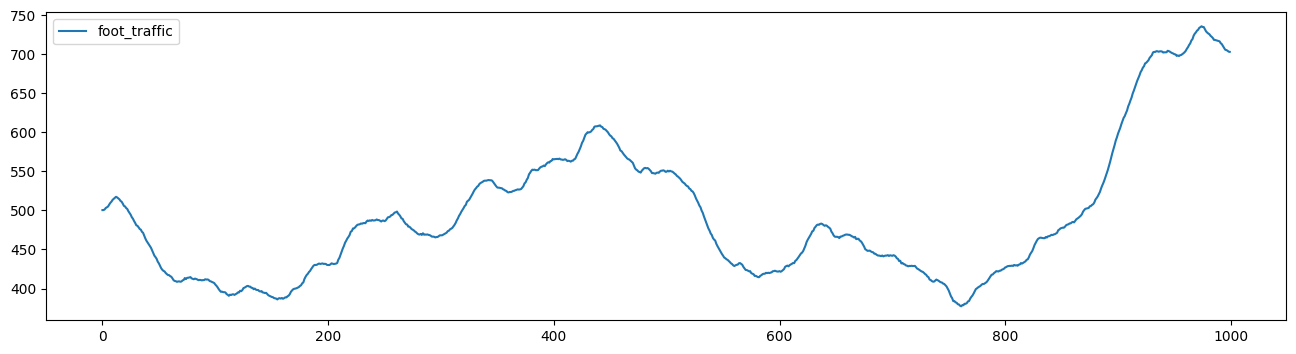

In [250]:
df_data.plot(figsize=(16,4), layout='constrained')

In [251]:
ADF_result = adfuller(df_data.foot_traffic)
ADF_result

(-1.175888599924075,
 0.6838808917896189,
 3,
 996,
 {'1%': -3.4369325637409154,
  '5%': -2.8644462162311934,
  '10%': -2.568317409920808},
 2740.300875453594)

In [253]:
foot_traffic_diff = np.diff(df_data.foot_traffic, n=1)

In [254]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})
df_diff.index = df_diff.index + 1
df_diff.head(5)

,foot_traffic_diff
1,0.025651
2,0.904511
3,1.869114
4,0.836705
5,1.039848


In [256]:
df_diff.shape

(999, 1)

<Axes: >

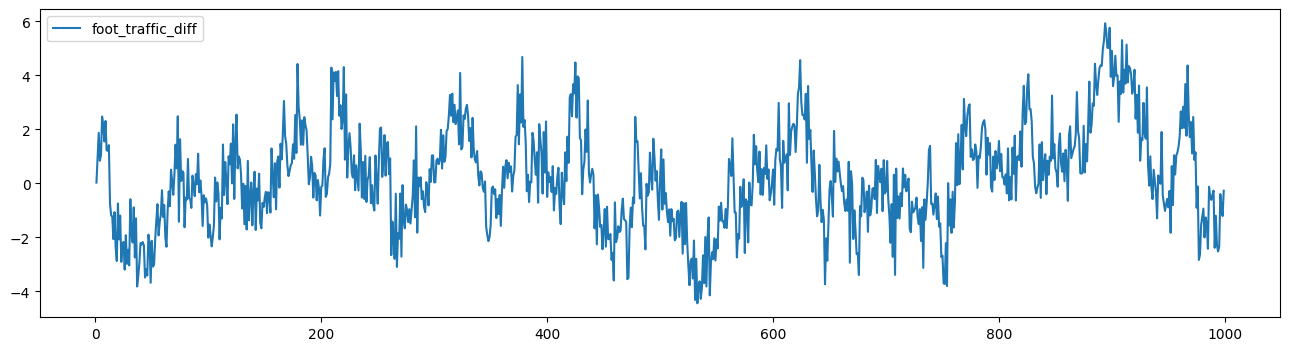

In [255]:
df_diff.plot(figsize=(16,4), layout='constrained')

In [257]:
ADF_result = adfuller(foot_traffic_diff)
ADF_result

(-5.268231347422037,
 6.3693176547815e-06,
 2,
 996,
 {'1%': -3.4369325637409154,
  '5%': -2.8644462162311934,
  '10%': -2.568317409920808},
 2735.535696297212)

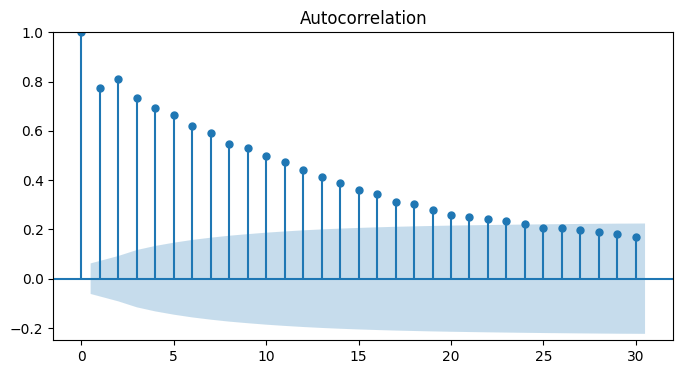

In [258]:
fig, ax = plt.subplots( figsize=(8,4) )
plot_acf(foot_traffic_diff, lags=30, ax=ax)
plt.ylim(-0.25, 1)
plt.show()

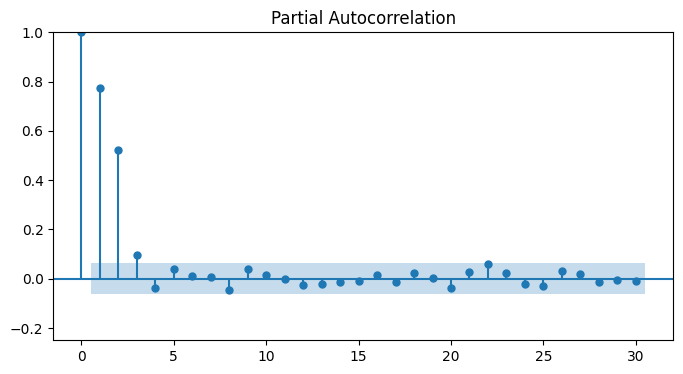

In [259]:
fig, ax = plt.subplots( figsize=(8,4) )
plot_pacf(foot_traffic_diff, lags=30, ax=ax)
plt.ylim(-0.25, 1)
plt.show()

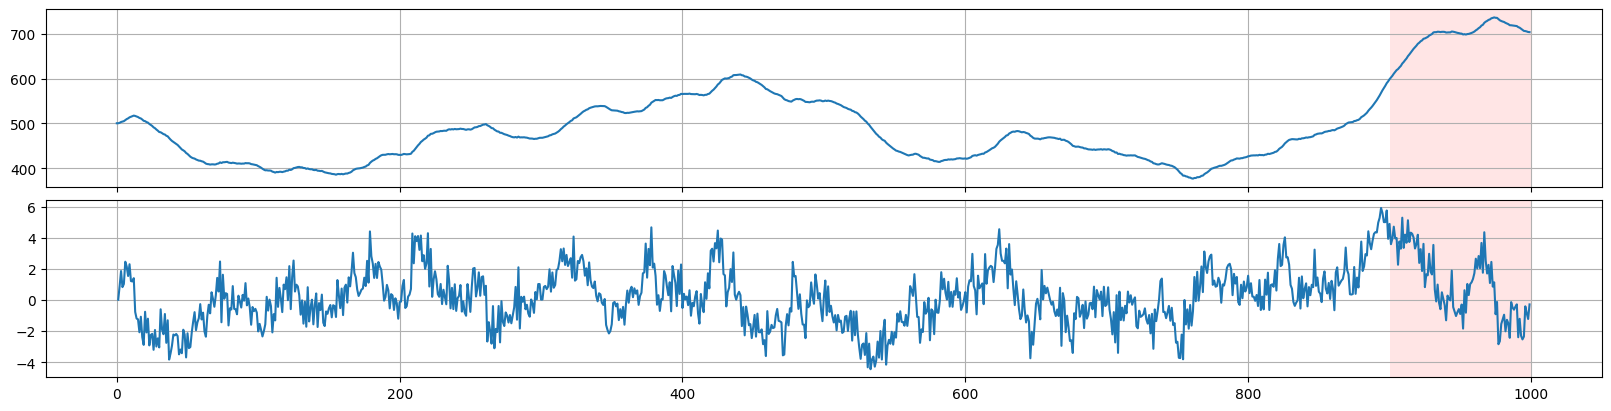

In [260]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,4),  layout='constrained')
ax1.plot(df_data )
ax1.grid()
ax1.axvspan(900, 1000, facecolor='red', alpha=0.1)
ax2.plot(df_diff)
ax2.grid()
ax2.axvspan(900,1000, facecolor='red', alpha=0.1)
plt.show()

In [261]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [262]:
train = df_diff[:-100]
test = df_diff[-100:]


TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head(5)

/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_64567/3398153448.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_64567/3398153448.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last_value'] = pred_last_value
/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_64567/3398153448.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
900,4.902001,0.103587,3.943732,4.529184
901,3.599489,0.108918,4.902001,4.041646
902,3.943638,0.112792,3.599489,3.899404
903,4.722737,0.117039,3.943638,3.479422
904,3.973385,0.122140,4.722737,3.769927


In [263]:
test.shape

(100, 4)

<Axes: >

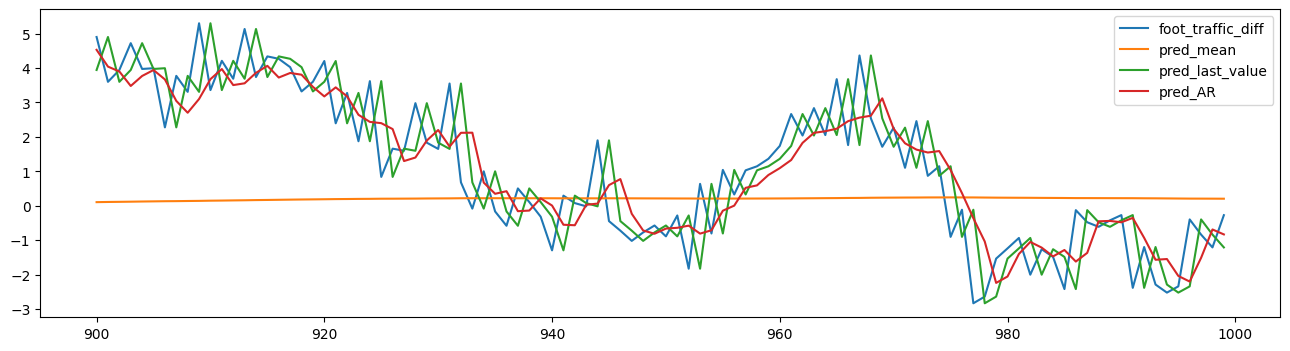

In [264]:
test.plot(figsize=(16,4), layout='constrained')

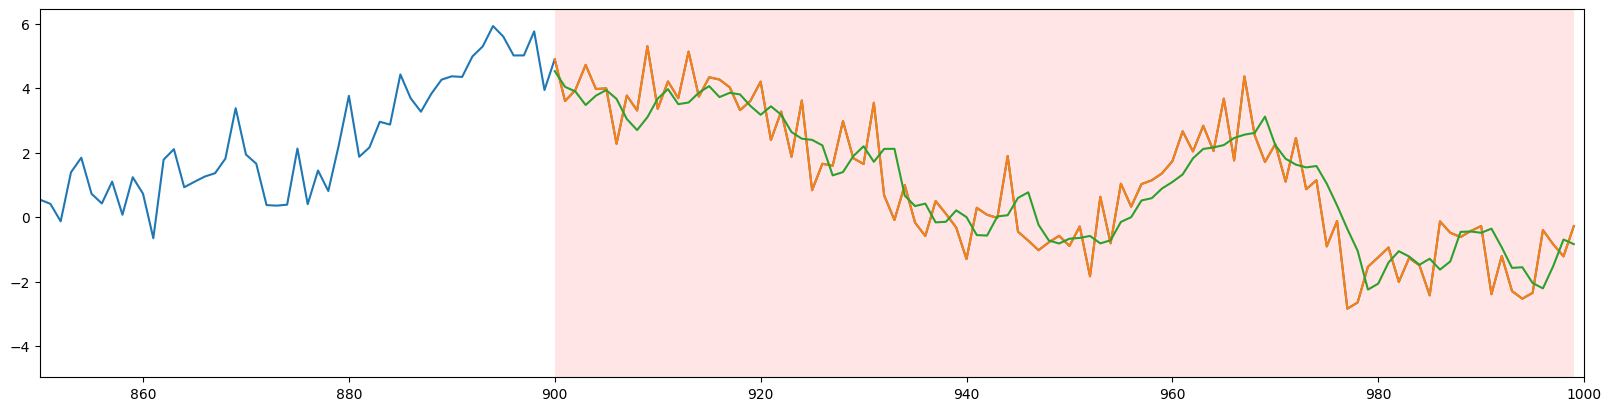

In [265]:
fig, ax = plt.subplots(figsize=(16,4), layout='constrained')

ax.plot(df_diff)
ax.plot(test[['foot_traffic_diff','pred_AR']])
ax.axvspan(900, 999, facecolor='red', alpha=0.1)
ax.set_xlim(850, 1000)
plt.show()

In [266]:
import torch
from torch import nn
mse = nn.MSELoss()
loss = {}

In [267]:
loss['mean'] =  mse( torch.FloatTensor( test['pred_mean'][:].values),  torch.FloatTensor(test['foot_traffic_diff'][:].values) ).item()
loss['last_value'] = mse( torch.FloatTensor( test['pred_last_value'][:].values),  torch.FloatTensor(test['foot_traffic_diff'][:].values) ).item()
loss['ar'] =  mse( torch.FloatTensor( test['pred_AR'][:].values),  torch.FloatTensor(test['foot_traffic_diff'][:].values) ).item()
loss

{'mean': 5.4753031730651855,
 'last_value': 1.4910247325897217,
 'ar': 0.9344965219497681}

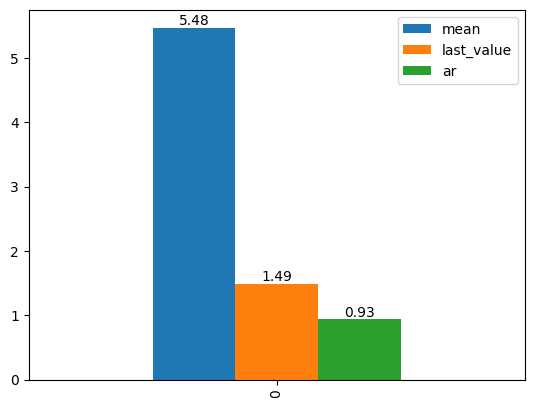

In [268]:
ax =  pd.DataFrame([loss]).plot.bar()
for index, label in enumerate(loss):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

In [269]:
df_data['pred_foot_traffic'] = pd.Series()
df_data.loc[900:, 'pred_foot_traffic'] = df_data.foot_traffic[900] + test.pred_AR.cumsum()
df_data.tail(10)

,foot_traffic,pred_foot_traffic
990,716.755410,718.029797
991,714.368652,717.676117
992,713.168108,716.742665
993,710.877523,715.172106
994,708.352665,713.622899
995,706.009031,711.582878
996,705.610549,709.378507
997,704.771335,707.863814
998,703.559920,707.173684
999,703.285236,706.339536


(850.0, 1000.0)

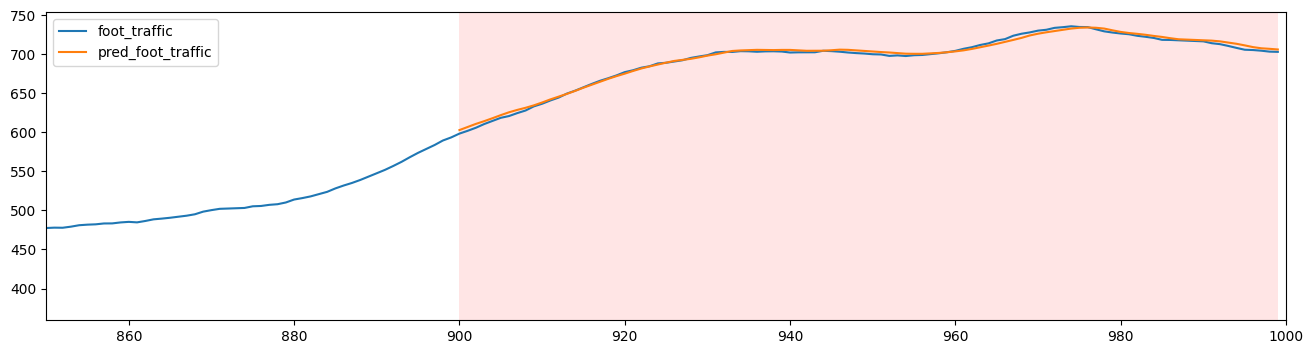

In [270]:
ax = df_data[:].plot(figsize=(16,4),  layout='constrained')
ax.axvspan(900, 999, facecolor='red', alpha=0.1)
ax.set_xlim(850, 1000)

In [271]:
df_data = df_data.astype('float64')

mae = nn.L1Loss()
loss = mae(
    torch.FloatTensor( df_data['pred_foot_traffic'][900:].values),  
    torch.FloatTensor(df_data['foot_traffic'][900:].values) 
).item()
loss

2.368992328643799